In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# --- 1. Generate the data ---
def runge_function(x):
    return 1.0 / (1.0 + 25.0 * x**2)

# Generate a dense set of points for plotting
x_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
y_plot = runge_function(x_plot)

# Significantly increase the number of training and validation points
num_train_points = 500
num_val_points = 20
x_train_np = np.linspace(-1, 1, num_train_points).reshape(-1, 1)
y_train_np = runge_function(x_train_np)

x_val_np = np.linspace(-1, 1, num_val_points).reshape(-1, 1)
y_val_np = runge_function(x_val_np)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
x_val = torch.tensor(x_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)
x_plot_tensor = torch.tensor(x_plot, dtype=torch.float32)

The training set size is set as 100, and the validation/text set size is set for 20.

In [3]:
# --- 2. Define the Neural Network ---
class RungeApproximator(nn.Module):
    def __init__(self, hidden_size=50):
        super(RungeApproximator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.net(x)

Here we create a 2-layer, with each layer 50 neurons, neural network, for which the activation function is selected as $\tanh x$.

In [4]:
# --- 3. Custom Loss Function for Sup-norm Approximation ---
class LPNormLoss(nn.Module):
    def __init__(self, p=20):
        super(LPNormLoss, self).__init__()
        self.p = p

    def forward(self, y_pred, y_true):
        error = torch.abs(y_pred - y_true)
        epsilon = 1e-10
        log_term = self.p * torch.log(error + epsilon)
        log_sum = torch.logsumexp(log_term, dim=0)
        loss = log_sum / self.p
        return loss

The programme has 2 different methods of approximation for which differ by the selection of optimiser. One with standard **MSE** method; while the other with **sup-norm** (also **infinity-norm**). We aim to compare the approximation results between both methods.

The loss function for the **sup-norm** is given by:
$$ L_{sup} = \frac{1}{p} \log\left(\sum_{i = 1}^{N} \exp(p\log(\mid y_i - \hat{y}_i\mid))\right) $$
 where $N$ is the size of teh training set, $p$ for sufficient large integer, here picked as 20.

We first start with the **MSE** method, to be fair, we set the *epoch* to 5000. And the loss after per 500 recurrences will be displayed in the output.

In [5]:
# --- 4. Training with MSE Loss ---
print("--- Training with MSE Loss ---")

model_mse = RungeApproximator()
optimizer_mse = optim.Adam(model_mse.parameters(), lr=0.01)
criterion_mse = nn.MSELoss()

epochs = 5000
train_loss_history_mse = []
val_loss_history_mse = []

for epoch in range(epochs):
    model_mse.train()
    optimizer_mse.zero_grad()
    
    y_pred = model_mse(x_train)
    loss = criterion_mse(y_pred, y_train)
    
    loss.backward()
    optimizer_mse.step()
    
    model_mse.eval()
    with torch.no_grad():
        y_val_pred = model_mse(x_val)
        val_loss = criterion_mse(y_val_pred, y_val)
        
    train_loss_history_mse.append(loss.item())
    val_loss_history_mse.append(val_loss.item())

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')

--- Training with MSE Loss ---
Epoch [500/5000], Train Loss: 0.000003, Val Loss: 0.000003
Epoch [1000/5000], Train Loss: 0.000001, Val Loss: 0.000001
Epoch [1500/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [2000/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [2500/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [3000/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [3500/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [4000/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [4500/5000], Train Loss: 0.000001, Val Loss: 0.000000
Epoch [5000/5000], Train Loss: 0.000000, Val Loss: 0.000000


Here we visualise the result getting from the **MSE** method.

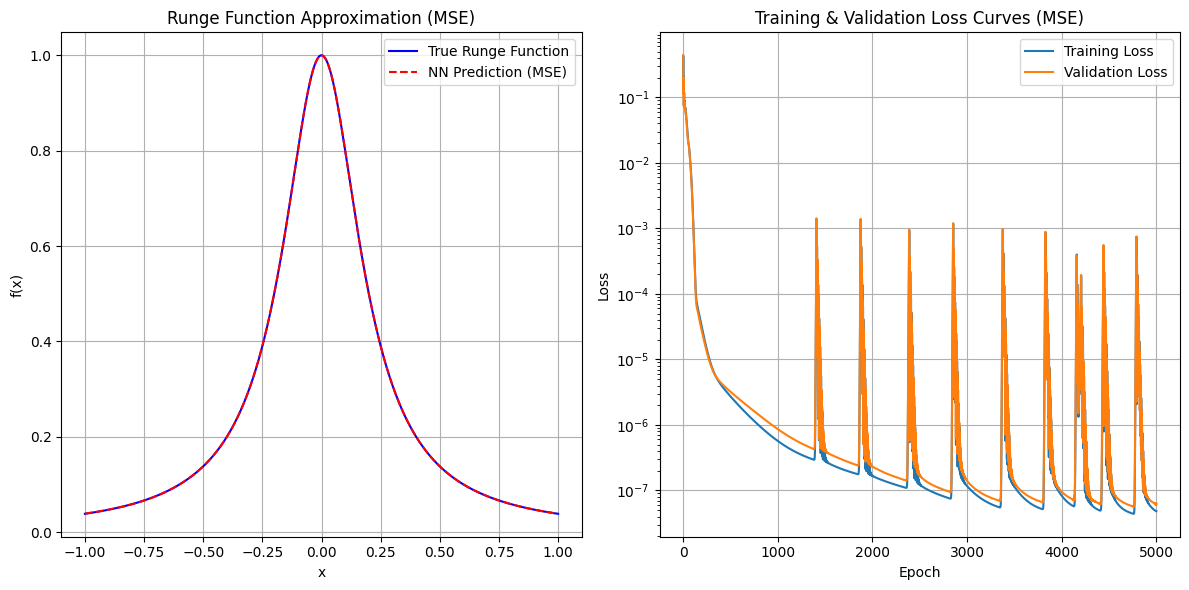

Final MSE: 0.000000
Final Max Absolute Error (Sup-norm): 0.000755


In [6]:
# --- 5. Evaluation and Plotting for MSE ---
model_mse.eval()
with torch.no_grad():
    y_pred_mse = model_mse(x_plot_tensor).numpy()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_plot, y_plot, label='True Runge Function', color='blue')
plt.plot(x_plot, y_pred_mse, label='NN Prediction (MSE)', color='red', linestyle='--')
plt.title('Runge Function Approximation (MSE)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_history_mse, label='Training Loss')
plt.plot(val_loss_history_mse, label='Validation Loss')
plt.title('Training & Validation Loss Curves (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

mse_val_error_mse = np.mean((y_pred_mse - y_plot)**2)
max_abs_error_val_mse = np.max(np.abs(y_pred_mse - y_plot))
print(f"Final MSE: {mse_val_error_mse:.6f}")
print(f"Final Max Absolute Error (Sup-norm): {max_abs_error_val_mse:.6f}")

In [7]:
# --- 6. Training with Sup-norm Approximation Loss ---
print("\n--- Training with Sup-norm Approximation Loss (Corrected) ---")

model_sup = RungeApproximator()
optimizer_sup = optim.Adam(model_sup.parameters(), lr=0.01)
criterion_sup = LPNormLoss(p=20)

epochs = 5000
train_loss_history_sup = []
val_loss_history_sup = []

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sup, 'min', patience=200, factor=0.5)

for epoch in range(epochs):
    model_sup.train()
    optimizer_sup.zero_grad()
    
    y_pred = model_sup(x_train)
    loss = criterion_sup(y_pred, y_train)
    
    loss.backward()
    optimizer_sup.step()
    
    model_sup.eval()
    with torch.no_grad():
        y_val_pred = model_sup(x_val)
        val_loss = criterion_sup(y_val_pred, y_val)
    
    scheduler.step(val_loss)
        
    train_loss_history_sup.append(loss.item())
    val_loss_history_sup.append(val_loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')


--- Training with Sup-norm Approximation Loss (Corrected) ---
Epoch [1000/5000], Train Loss: -3.462266, Val Loss: -3.617931
Epoch [2000/5000], Train Loss: -4.721003, Val Loss: -4.759201
Epoch [3000/5000], Train Loss: -6.973264, Val Loss: -7.292181
Epoch [4000/5000], Train Loss: -7.424838, Val Loss: -7.551247
Epoch [5000/5000], Train Loss: -7.429914, Val Loss: -7.556396


The following is for the **sup-norm** method. Again, the *epoch* and other parametres are set as the ones in **MSE** method.

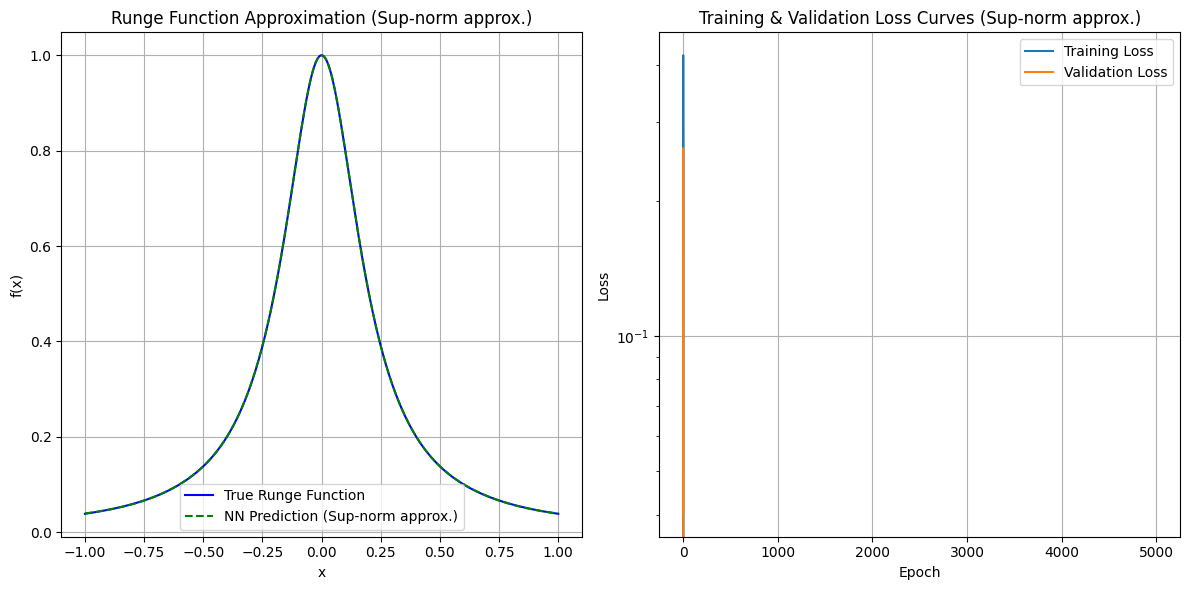

Final MSE: 0.000000
Final Max Absolute Error (Sup-norm): 0.000696


In [8]:
# --- 7. Evaluation and Plotting for Sup-norm ---
model_sup.eval()
with torch.no_grad():
    y_pred_sup = model_sup(x_plot_tensor).numpy()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_plot, y_plot, label='True Runge Function', color='blue')
plt.plot(x_plot, y_pred_sup, label='NN Prediction (Sup-norm approx.)', color='green', linestyle='--')
plt.title('Runge Function Approximation (Sup-norm approx.)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_history_sup, label='Training Loss')
plt.plot(val_loss_history_sup, label='Validation Loss')
plt.title('Training & Validation Loss Curves (Sup-norm approx.)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

mse_val_error_sup = np.mean((y_pred_sup - y_plot)**2)
max_abs_error_val_sup = np.max(np.abs(y_pred_sup - y_plot))
print(f"Final MSE: {mse_val_error_sup:.6f}")
print(f"Final Max Absolute Error (Sup-norm): {max_abs_error_val_sup:.6f}")

One may ask why the losses between 2 methods can vary so much. The reason is quite simple, different optimisers needs different scales, direct comparison cannnot really distinguish which method is better. Hence we try to re-scale the loss in the **sup-norm** method, and further do the comparison.

In [13]:
# --- 8. Final Comparison of Results ---
print("\n--- Final Results Comparison ---")

print("----------------------------------------------------------------------")
print("         Metric         |    MSE Method   | Sup-Norm Method")
print("----------------------------------------------------------------------")
print(f"Final MSE               |  {mse_val_error_mse:.6f}       |  {mse_val_error_sup:.6f}")
print(f"Final Max Abs Error     |  {max_abs_error_val_mse:.6f}       |  {max_abs_error_val_sup:.6f}")
print("----------------------------------------------------------------------")

# Determine which method is "better" based on max absolute error
# since that is the metric the sup-norm method is designed to optimize.
if max_abs_error_val_sup < max_abs_error_val_mse:
    print("\nConclusion: The Sup-Norm method achieved a lower maximum absolute error, making it the better method for this specific objective.")
elif max_abs_error_val_mse < max_abs_error_val_sup:
    print("\nConclusion: The MSE method achieved a lower maximum absolute error, making it the better method for this specific objective.")
else:
    print("\nConclusion: Both methods achieved a very similar result for the maximum absolute error.")


--- Final Results Comparison ---
----------------------------------------------------------------------
         Metric         |    MSE Method   | Sup-Norm Method
----------------------------------------------------------------------
Final MSE               |  0.000000       |  0.000000
Final Max Abs Error     |  0.001162       |  0.000696
----------------------------------------------------------------------

Conclusion: The Sup-Norm method achieved a lower maximum absolute error, making it the better method for this specific objective.


The result shows that under the same amount of time and the same condition, **sup-norm** method is the better of the two.\
One may ask about the running time, in theoretical perspective, they share the same time complexity of $\mathcal{O}(N)$ for the computation of loss function, for $N$ stands for the size of the training data set.\
The tradeoff of the **sup-norm** method, I think is the computational formula complexity, the loss function involves *logrithm* and the *exponential* function,it is not easy yo take the derivative for a good form, so it is not as simple as the **MSE** when calculating the loss by hands.